<a href="https://colab.research.google.com/github/rafiag/DTI2020/blob/main/004_Classification_Bank_Marketing_Dataset_(Assignment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In machine  learning  and statistics,  classification  is the problem  of identifying  to which  of a set of categories (sub-populations)  a new observation  belongs,  based  on a training  set of data containing observations  (or instances)  whose  category membership  is known. Examples of classification problems are assigning  a given email to the "spam" or "non-spam" class, and assigning  a diagnosis  to a given patient  based  on observed  characteristics  of the patient  (sex,  blood pressure, presence  or absence of certain symptoms, etc.)

In this notebook we will use the [Bank Marketing Dataset](https://www.kaggle.com/janiobachmann/bank-marketing-dataset) from Kaggle to build a model to predict whether someone is going to make a deposit or not depending on some attributes. We wiill try to build 4 models using different algorithm Decision Tree, Random Forest, Naive Bayes, and K-Nearest Neighbors. After building each model we will evalueate them and compare which model are the best for our case. We will then try to optimze our model by tuning the hyper paramters of the model by using GridSearch. Lastly, we will save the prediction result from our dataset and then save our model for reussability.

To start we will load some basic libraries such as Pandas and NumPy and then make some configuration to some of those libraries.

In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

# Data Pre-Processing

Before we can begin to create our first model we first need to load and pre-process. This step ensure that our model will receive a good data to learn from, as they said "a model is only as good as it's data". The data pre-processing will be divided into few steps as explained below.

## Loading data

In this first step we will load our dataset that has been uploaded on my GitHub for easier process. From the dataset documentation found [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) we can see below are the list of column we have in our data:

Input variables:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y. has the client subscribed a term deposit? (binary: 'yes','no')

According to the dataset documentation, we need to remove the 'duration' column because in real-case the duration is only known after the label column is known. This problem can be considered to be 'data leakage' where predictors include data that will not be available at the time you make predictions.

In [5]:
# Load dataset
df_bank = pd.read_csv('https://raw.githubusercontent.com/rafiag/DTI2020/main/data/bank.csv')

# Drop 'duration' column
df_bank = df_bank.drop('duration', axis=1)

# print(df_bank.info())
print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


## Class Distribution

Another important thing to make sure before feeding our data into the model is the class distribution of the data. In our case where the expected class are divided into two outcome, 'yes' and 'no', a class distribution of 50:50 can be considered ideal.

In [6]:
df_bank['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

As we can see our class distribution is more or less similar, not exactly 50:50 distribution but still good enough.

## Missing Values

Last thing to check before moving on is missing values. In some case our data might have missing values in some column, this can be caused some reasons such as human error. We can use the `is_null()` function from Pandas to check for any missing data and then use the `sum()` function to see the total of missing values in each column.

In [7]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

From the result we can be assured that our data have no missing value and are good to go. In the case where you did have missing value in your data you can solve it by doing imputation or just remove the column altogether depending on your case. [Here](https://www.kaggle.com/dansbecker/handling-missing-values) is a good Kaggle course on how to handle missing value in dataset.

## Scale Numeric Data

Next up, we will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*

In [9]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready = df_bank.copy()

scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready[num_cols] = scaler.fit_transform(df_bank[num_cols])

df_bank_ready.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,1.491505,admin.,married,secondary,no,0.252525,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
1,1.239676,admin.,married,secondary,no,-0.459974,no,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
2,-0.019470,technician,married,secondary,no,-0.080160,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
3,1.155733,services,married,secondary,no,0.293762,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
4,1.071790,admin.,married,tertiary,no,-0.416876,no,no,unknown,-1.265746,may,-0.186785,-0.481184,-0.36326,unknown,yes


## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |

In this code cell we will also encode our label column by replacing 'yes' and 'no' with 1 and 0 respectively. We can do this by applying simple lambda/in-line function on the column.

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready = df_bank_ready.drop(cat_cols ,axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)

# Encode target value
df_bank_ready['deposit'] = df_bank_ready['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready.head()

Shape of dataframe: (11162, 51)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.491505,0.252525,-1.265746,-0.554168,-0.481184,-0.36326,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.239676,-0.459974,-1.265746,-0.554168,-0.481184,-0.36326,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.019470,-0.080160,-1.265746,-0.554168,-0.481184,-0.36326,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.155733,0.293762,-1.265746,-0.554168,-0.481184,-0.36326,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.071790,-0.416876,-1.265746,-0.186785,-0.481184,-0.36326,1


## Split Dataset for Training and Testing

To finish up our data pre-processing steps we will split our data into two dataset, training and testing. In this case because we have enough data we will split the data with ratio of 80:20 for training and testing respectively. This will result in our training data having 8929 rows and 2233 rows for the testing data.

In [11]:
# Select Features
feature = df_bank_ready.drop('deposit', axis=1)

# Select Target
target = df_bank_ready['deposit']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8929, 50)
(2233, 50)
(8929,)
(2233,)


# Modeling

After making sure our data is good and ready we can continue to building our model. In this notebook we will try to build 4 different models with different algorithm. In this step we will create a baseline model for each algorithm using the default paramaeters set by sklearn and after building all 4 of our models we will compare them to see which works best for our case.

To evaluate our model we will use the confusion matrix as our base for the evaluation.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
where: TP = True Positive; FP = False Positive; TN = True Negative; FN = False Negative.

We will use 6 metrics below to evaluate models:

1. Accuracy: the proportion of true results among the total number of cases examined.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>
2. Precision: used to calculate how much proportion of all data that was predicted positive **was** actually positive.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>
3. Recall: used to calculate how much proportion of actual positives is correctly classified.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>
4. F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>
5. Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
<div align='center'>$\kappa = \frac{p_o-p_e}{1-p_e}$</div>
    where $p_o$ is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and $p_e$ is the expected agreement when both annotators assign labels randomly. $p_e$ is estimated using a per-annotator empirical prior over the class labels.
6. Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes

In this case we want to focus on the recall value of our model because in our problem we should try to predict as many actual positive as we can. Because a misclassification of customer who **actually** wanted to make a deposit can mean a lose opportunity/revenue.

## Decision Tree

Decision tree is a tree shaped diagram used to determine a course of action. Each branch of the tree represents a possible decision, occurrence or reaction.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/decision_tree.PNG' height='250'></div>

Advantages:
* Inexpensive to construct
* Extremely fast at classifying unknown records
* Easy to interpret for small-sized trees•
* Accuracy is comparable to other classification techniques for many simple data sets

Disadvantages:
* Overfitting when algorithm capture noise in the data
* The model can get unstable due to small variation of data
* Low biased tree: difficult for the model to work with new data

### Building Model

In [12]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Predict to Test Data 
y_pred_dtc = dtc.predict(X_test)

### Model Evaluation

In [13]:
from sklearn import metrics

# Calculate accuracy, precision, recall, f1-score, and kappa score
dtc_acc = metrics.accuracy_score(y_test, y_pred_dtc)
dtc_prec = metrics.precision_score(y_test, y_pred_dtc)
dtc_rec = metrics.recall_score(y_test, y_pred_dtc)
dtc_f1 = metrics.f1_score(y_test, y_pred_dtc)
dtc_kappa = metrics.cohen_kappa_score(y_test, y_pred_dtc)

print('Accuracy:', dtc_acc)
print('Precision:', dtc_prec)
print('Recall:', dtc_rec)
print('F1 Score:', dtc_f1)
print('Cohens Kappa Score:', dtc_kappa)

# Calculate area under curve (AUC)
y_pred_dtc_proba = dtc.predict_proba(X_test)[::,1]
dtc_fpr, dtc_tpr, _ = metrics.roc_curve(y_test,  y_pred_dtc_proba)
dtc_auc = metrics.roc_auc_score(y_test, y_pred_dtc_proba)
print('Area Under Curve:', dtc_auc)

# Display confussion matrix
dtc_cm = metrics.confusion_matrix(y_test, y_pred_dtc)
print('Confusion Matrix:\n', dtc_cm)

Accuracy: 0.6336766681594268
Precision: 0.6215953307392996
Recall: 0.598314606741573
F1 Score: 0.6097328244274809
Cohens Kappa Score: 0.2648219403033133
Area Under Curve: 0.6322045136712157
Confusion Matrix:
 [[776 389]
 [429 639]]


## Random Forest

Random forest or Random Decision Forest is a method that operates by constructing multiple decision trees during training phases. The decision of the majority of the trees is chosen as final decision.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/random_forest.PNG' height='250'></div>

Advantages:
* It can be used for both regression and classification tasks and that it’s easy to view the relative importance it assigns to the input features.
* It is also considered as a very handy and easy to use algorithm, because it’s default hyper-parameters often produce a good prediction result.

Disadvantages:
* Many trees can make the algorithm to slow and ineffective for real-time predictions. A more accurate prediction requires more trees, which results in a slower model.
* It is a predictive modeling tool and not a descriptive tool.

### Building Model

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Predict to Test Data 
y_pred_rf = rf.predict(X_test)

### Model Evaluation

In [15]:
# Calculate accuracy, precision, recall, f1-score, and kappa score
rf_acc = metrics.accuracy_score(y_test, y_pred_rf)
rf_prec = metrics.precision_score(y_test, y_pred_rf)
rf_rec = metrics.recall_score(y_test, y_pred_rf)
rf_f1 = metrics.f1_score(y_test, y_pred_rf)
rf_kappa = metrics.cohen_kappa_score(y_test, y_pred_rf)

print('Accuracy:', rf_acc)
print('Precision:', rf_prec)
print('Recall:', rf_rec)
print('F1 Score:', rf_f1)
print('Cohens Kappa Score:', rf_kappa)

# Calculate area under curve (AUC)
y_pred_rf_proba = rf.predict_proba(X_test)[::,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
rf_auc = metrics.roc_auc_score(y_test, y_pred_rf_proba)
print('Area Under Curve:', rf_auc)

# Display confussion matrix
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:\n', rf_cm)

Accuracy: 0.7205553067622034
Precision: 0.7488789237668162
Recall: 0.6254681647940075
F1 Score: 0.6816326530612244
Cohens Kappa Score: 0.43618595045335207
Area Under Curve: 0.781940492838887
Confusion Matrix:
 [[941 224]
 [400 668]]


## Naive Bayes

Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. Below are the Bayes theorem formula:

<div align="center">$P(C | A) = \frac{P(A|C) P(C)}{P(A)}$</div>

For example, given:
* A doctor knows that meningitis  causes  stiff neck 50% of the time
* Prior probability  of any patient  having  meningitis  is 1/50,000
* Prior probability  of any patient  having  stiff neck is 1/20

Then the probability of patient who have stiff neck to also have meningitis is:

<div align="center">$P(C | A) = \frac{P(A|C) P(C)}{P(A)} = \frac{0.5 * (1 / 50000)}{1 / 20} = 0.0002$</div>

### Building Model

In [16]:
from sklearn.naive_bayes import GaussianNB

# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict to Test Data 
y_pred_nb = nb.predict(X_test)

### Model Evaluation

In [17]:
# Calculate accuracy, precision, recall, f1-score, and kappa score
nb_acc = metrics.accuracy_score(y_test, y_pred_nb)
nb_prec = metrics.precision_score(y_test, y_pred_nb)
nb_rec = metrics.recall_score(y_test, y_pred_nb)
nb_f1 = metrics.f1_score(y_test, y_pred_nb)
nb_kappa = metrics.cohen_kappa_score(y_test, y_pred_nb)

print('Accuracy:', nb_acc)
print('Precision:', nb_prec)
print('Recall:', nb_rec)
print('F1 Score:', nb_f1)
print('Cohens Kappa Score:', nb_kappa)

# Calculate area under curve (AUC)
y_pred_nb_proba = nb.predict_proba(X_test)[::,1]
nb_fpr, nb_tpr, _ = metrics.roc_curve(y_test,  y_pred_nb_proba)
nb_auc = metrics.roc_auc_score(y_test, y_pred_nb_proba)
print('Area Under Curve:', nb_auc)

# Display confussion matrix
nb_cm = metrics.confusion_matrix(y_test, y_pred_nb)
print('Confusion Matrix:\n', nb_cm)

Accuracy: 0.6815942678011644
Precision: 0.7560975609756098
Recall: 0.4934456928838951
F1 Score: 0.5971671388101983
Cohens Kappa Score: 0.352622455965517
Area Under Curve: 0.7421999324878237
Confusion Matrix:
 [[995 170]
 [541 527]]


## K-Nearest Neighbors

K-Nearest Neighbors (KNN) classify new data by finding k-number of closest neighbor from the training data and then decide the class based on the majority of it's neighbors. For example in the image below where $k = 3$ majority of it's neighbor is classified as B, but when $k = 7$ the majority will changes to A.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/knn.PNG' height='200'></div>

Advantages:
* Simple technique that is easily implemented
* Building model is cheap
* Extremely flexible classification scheme

Disadvantages:
* Classifying unknown records are relatively expensive
* Requires distance computation of k-nearest neighbors
* Computationally intensive, especially when the size of the training set grows
* Accuracy can be severely degraded by the presence of noisy or irrelevant features

### Building Model

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict to Test Data 
y_pred_knn = knn.predict(X_test)

### Model Evaluation

In [19]:
# Calculate accuracy, precision, recall, f1-score, and kappa score
knn_acc = metrics.accuracy_score(y_test, y_pred_knn)
knn_prec = metrics.precision_score(y_test, y_pred_knn)
knn_rec = metrics.recall_score(y_test, y_pred_knn)
knn_f1 = metrics.f1_score(y_test, y_pred_knn)
knn_kappa = metrics.cohen_kappa_score(y_test, y_pred_knn)

print('Accuracy:', knn_acc)
print('Precision:', knn_prec)
print('Recall:', knn_rec)
print('F1 Score:', knn_f1)
print('Cohens Kappa Score:', knn_kappa)

# Calculate area under curve (AUC)
y_pred_knn_proba = knn.predict_proba(X_test)[::,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
knn_auc = metrics.roc_auc_score(y_test, y_pred_knn_proba)
print('Area Under Curve:', knn_auc)

# Display confussion matrix
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
print('Confusion Matrix:\n', knn_cm)

Accuracy: 0.6869682042095835
Precision: 0.6981740064446831
Recall: 0.6086142322097379
F1 Score: 0.6503251625812906
Cohens Kappa Score: 0.3693851405429406
Area Under Curve: 0.7323909758724342
Confusion Matrix:
 [[884 281]
 [418 650]]


## Model Comparison

After building all of our model, we can now compare how well each model perform. To do this we will create two chart, first is a grouped bar chart to display the value of accuracy, precision, recall, f1, and kappa score of our model, and second a line chart to show the AUC of all our models.

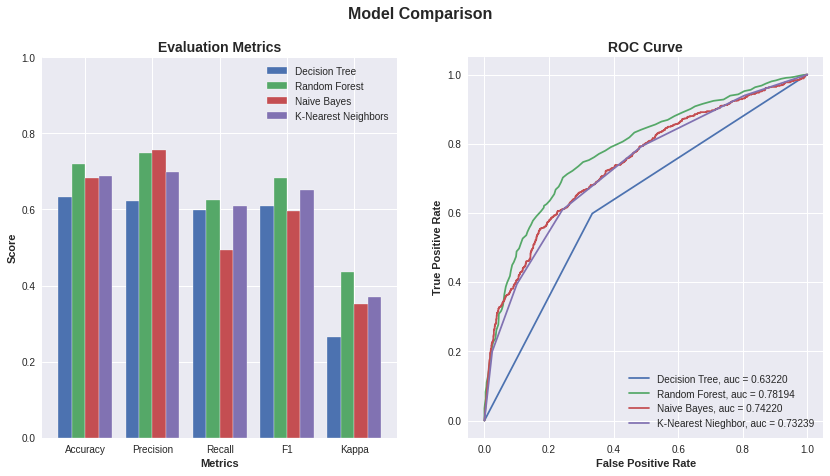

In [22]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_acc, dtc_prec, dtc_rec, dtc_f1, dtc_kappa]
rf_score = [rf_acc, rf_prec, rf_rec, rf_f1, rf_kappa]
nb_score = [nb_acc, nb_prec, nb_rec, nb_f1, nb_kappa]
knn_score = [knn_acc, knn_prec, knn_rec, knn_f1, knn_kappa]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_fpr, dtc_tpr, label='Decision Tree, auc = {:0.5f}'.format(dtc_auc))
ax2.plot(rf_fpr, rf_tpr, label='Random Forest, auc = {:0.5f}'.format(rf_auc))
ax2.plot(nb_fpr, nb_tpr, label='Naive Bayes, auc = {:0.5f}'.format(nb_auc))
ax2.plot(knn_fpr, knn_tpr, label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_auc))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

Judging from the figures above we can see that our Random Forest model tops the other models in 5 of the 6 metrics we evaluate, except precision. So we can assume that Random Forest is the right choice to solve our problem.

# Model Optimization

On the next part of this notebook, we will try to optimze our RandomForest model by tuning the hyperparamters available from the scikit-learn library. After finding the optimal parameters we will then evaluate our new model by comparing it against our base line model before.

## Tuning Hyperparameter with GridSearchCV

We will use `GridSearchCV` functionality from sklearn to find the optimal parameter for our model. We will provide our baseline model (named `rf_grids`), scoring method (in our case we will use recall as explained before), and also various parameters value we want to try with our model. The `GridSearchCV` function will then iterate through each parameters combination to find the best scoring parameters.

This function also allow us to use cross validation to train our model, where on each iteration our data will be splitted into 5 (the number are adjustable from the parameter) fold. The models then will be trained on 4/5 fold of the data leaving the final fold as validation data, this process will be repeated for 5 times until all of our folds are used as validation data.

<div align='center'><img src='https://i.imgur.com/9k60cVA.png' height='200'></div>

To see the result of which parameters combination works best we can acces the `best_params_` attribute from our grid search object.

*Note: The more combination provided, the longer the process will take. Alternatively, you can also try `RandomizedSearchCV` to only randomly select specified number of parameters which can result in faster running time.*

In [23]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 750, 1000]
}

# Create a base model
rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 72.0min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 73.9min finished


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 750}

## Evaluating Optimized Model

After finding the best parameter for the model we can access the `best_estimator_` attribute of the GridSearchCV object to save our optimized model into variable called `best_grid`. We will calculate the 6 evaluation metrics to compare it with our base model on the next step.

In [24]:
best_grid = grid_search.best_estimator_
best_grid_pred = best_grid.predict(X_test)

# Calculate accuracy, precision, recall, f1-score, and kappa score
best_grid_acc = metrics.accuracy_score(y_test, best_grid_pred)
best_grid_prec = metrics.precision_score(y_test, best_grid_pred)
best_grid_rec = metrics.recall_score(y_test, best_grid_pred)
best_grid_f1 = metrics.f1_score(y_test, best_grid_pred)
best_grid_kappa = metrics.cohen_kappa_score(y_test, best_grid_pred)

# Calculate area under curve (AUC)
best_grid_pred_proba = best_grid.predict_proba(X_test)[::,1]
best_grid_fpr, best_grid_tpr, _ = metrics.roc_curve(y_test,  best_grid_pred_proba)
best_grid_auc = metrics.roc_auc_score(y_test, best_grid_pred_proba)

## Model Comparison

The code below will draw the same plot as before only with our original Random Forest model and it's optimized version. It will also print the change on each evaluation mterics to help us see if our optimized model work better than the original one.

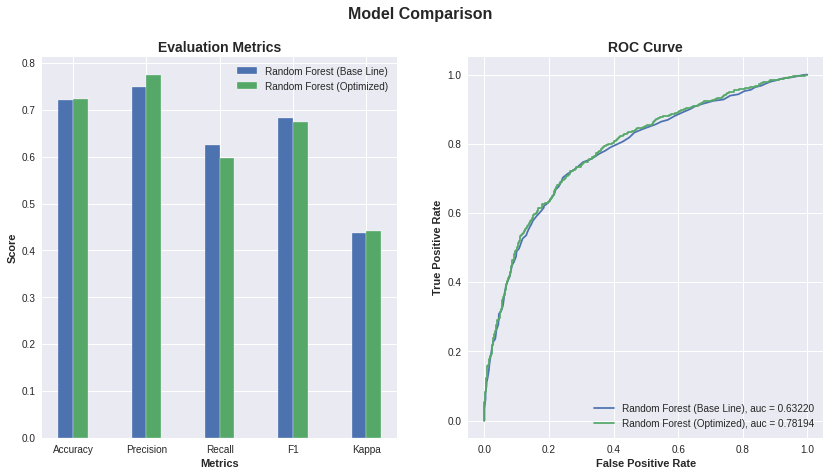

Change of 0.50% on accuracy.
Change of 3.30% on precision.
Change of -4.34% on recall.
Change of -1.01% on F1 score.
Change of 1.33% on Kappa score.
Change of 0.83% on AUC.


In [26]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_acc, rf_prec, rf_rec, rf_f1, rf_kappa]
best_grid_score = [best_grid_acc, best_grid_prec, best_grid_rec, best_grid_f1, best_grid_kappa]    

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_fpr, rf_tpr, label='Random Forest (Base Line), auc = {:0.5f}'.format(dtc_auc))
ax2.plot(best_grid_fpr, best_grid_tpr, label='Random Forest (Optimized), auc = {:0.5f}'.format(rf_auc))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * (best_grid_acc - rf_acc) / rf_acc))
print('Change of {:0.2f}% on precision.'.format(100 * (best_grid_prec - rf_prec) / rf_prec))
print('Change of {:0.2f}% on recall.'.format(100 * (best_grid_rec - rf_rec) / rf_rec))
print('Change of {:0.2f}% on F1 score.'.format(100 * (best_grid_f1 - rf_f1) / rf_f1))
print('Change of {:0.2f}% on Kappa score.'.format(100 * (best_grid_kappa - rf_kappa) / rf_kappa))
print('Change of {:0.2f}% on AUC.'.format(100 * (best_grid_auc - rf_auc) / rf_auc))

The result show that our optimized performed little bit better than the original model. The optimized models show an increase in 4 out of the 6 metrics but perform worse in the other metrics, especially the recall with -4.34% decrease. Because we want to focus on predicting as many actual positive values as possible we should stick with our original model for the prediction because it has higher recall score.

# Output

## Prediction

In this step we will predict the expected outcome of all the row from our dataset then save it into a csv file for easier access in the future.

In [27]:
df_bank['deposit_prediction'] = rf.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x: 'yes' if x==0 else 'no')

# Save new dataframe into csv file
df_bank.to_csv('deposit_prediction.csv', index=False)

df_bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,2,-1,0,unknown,yes,no
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1,-1,0,unknown,yes,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1,-1,0,unknown,yes,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,1,-1,0,unknown,yes,no
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,3,-1,0,unknown,yes,no


## Saving model

We can also save our model for further model reusability. This model can then be loaded on another machine to make new prediction without doing the whole training process again.

In [28]:
from joblib import dump, load

# Saving model
dump(rf, 'bank_deposit_classification.joblib')
# Loading model
# clf = load('bank_deposit_classification.joblib') 

['bank_deposit_classification.joblib']

# Conclusion

For a simple model we can see that our model did decently on classifying the data. But there are still some weakness on our model, especially shown on the recall metric where we only get about 60%. This means that our model are only able to detect 60% of potential customer and miss the other 40%. The result is not that much different after optimizing the model using `GridSearchCV` which can means that we hit our limit with this model. To imporove our performance we can try to look into another algorithm such as `GradientBoostingClassifier`.

# References

1. Telkom Digital Talent Incubator - Data Scientist Module 5 (Classification)
2. [Scikit-learn Documentation](https://scikit-learn.org/stable/index.html)
3. [The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
4. [The Python Graph Gallery - Grouped Bar Plot](https://python-graph-gallery.com/11-grouped-barplot/)